## Import the libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Import the dataset

In [4]:
dataset_filepath = '/Users/davronabdukhakimov/Desktop/RealEstate_California.csv'
raw_dataset = pd.read_csv(dataset_filepath)

# convert 'datePostedString' into column with date dtype
raw_dataset['date_posted'] = pd.to_datetime(raw_dataset['datePostedString'],format='%Y-%m-%d')

## Dealing with missing values

### Analyzing pricePerSquareFoot column

" from the scatterplot below we can see that multiplying pricePerSquareFoot by livingAreaValue gives the price (target variable)\nbut we don't know pricePerSquareFoot prior to knowing price value "

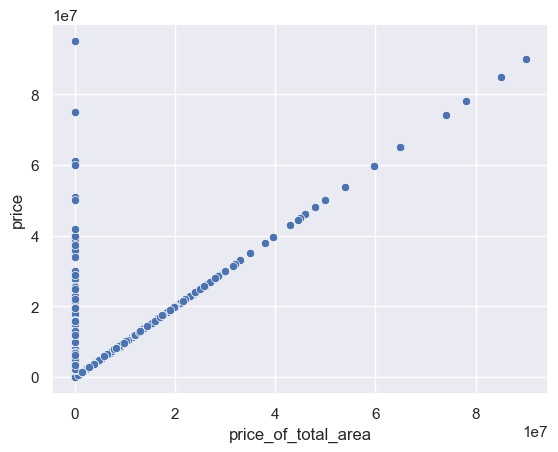

In [5]:
raw_dataset['price_of_total_area'] = raw_dataset['pricePerSquareFoot'] * raw_dataset['livingAreaValue']
sns.scatterplot(x=raw_dataset['price_of_total_area'],y =raw_dataset['price'])
''' from the scatterplot below we can see that multiplying pricePerSquareFoot by livingAreaValue gives the price (target variable)
but we don't know pricePerSquareFoot prior to knowing price value '''

### Drop unnecessary columns

In [6]:
# columns which are redundant
columns_to_drop = ['Unnamed: 0','cityId','id','stateId','currency','countyId','state','country','description',
                   'time','datePostedString','hasBadGeocode','is_bankOwned','is_forAuction','lotAreaUnits',
                  'pricePerSquareFoot','longitude','latitude']
clean_dataset = raw_dataset.drop(columns_to_drop,axis = 1)

### Drop rows with nan values, duplicates and rows with event type of rent

In [7]:
print(f"Start: {clean_dataset.shape}")
clean_dataset.dropna(inplace=True)
print(f"After dropna: {clean_dataset.shape}")
clean_dataset.drop_duplicates(inplace=True)
print(f"After dropping duplicates: {clean_dataset.shape}")

# only 4 entries for "Listed for rent"
clean_dataset = clean_dataset[clean_dataset['event'] != 'Listed for rent']
print(f"After dropping rent houses: {clean_dataset.shape}")
# only 1 entry for "APARTMENT"
clean_dataset.loc[clean_dataset['homeType'] == 'APARTMENT','homeType'] = 'CONDO'

# some features such as yearBuilt of lot properties are ambiguous 
clean_dataset = clean_dataset[clean_dataset['homeType'] != 'LOT']
clean_dataset = clean_dataset[clean_dataset['homeType'] != 'MULTI_FAMILY']
print(f"After dropping lot houses: {clean_dataset.shape}")
# only 1 entry for "Pending sale"
clean_dataset = clean_dataset[clean_dataset['event'] != 'Pending sale']
print(f"After dropping pending sale: {clean_dataset.shape}")

Start: (35389, 23)
After dropna: (35072, 23)
After dropping duplicates: (31038, 23)
After dropping rent houses: (31034, 23)
After dropping lot houses: (23219, 23)
After dropping pending sale: (23218, 23)


### Extract season from date_posted column

In [8]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'
    
clean_dataset['season_posted'] = clean_dataset['date_posted'].apply(get_season)
clean_dataset.drop('date_posted',axis=1,inplace=True)

### Extract street name from streetAddress column

In [9]:
split_address = clean_dataset['streetAddress'].str.split(' ',n=1,expand=True)
clean_dataset = clean_dataset[split_address[1].notna()]
clean_dataset = clean_dataset[split_address[0].str.isdigit()]
clean_dataset['street_name'] = split_address[1]
clean_dataset.drop('streetAddress',axis = 1,inplace=True)

/var/folders/r1/m92fhd0n5mq0_bh6sg3_pnlh0000gn/T/ipykernel_23285/2322718560.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_dataset = clean_dataset[split_address[0].str.isdigit()]


### Drop livingArea since the column contains the same values as livingAreaValue column

In [10]:
# there is only 1 entry where livingArea and livingAreaValue have different values
clean_dataset.drop('livingArea',axis=1,inplace=True)

### Copy values from buildingArea to livingAreaValue

In [11]:
print(clean_dataset[(clean_dataset['buildingArea'] != 0) & (clean_dataset['livingAreaValue'] == 0)].shape)
clean_dataset.loc[(clean_dataset['buildingArea'] != 0) & (clean_dataset['livingAreaValue'] == 0), 'livingAreaValue'] = clean_dataset['buildingArea']
clean_dataset.drop('buildingArea',axis=1,inplace=True)

(0, 22)


### Drop hasGarage column since garageSpaces column is more informative

In [12]:
print(f"hasGarage = 1 and garageSpaces = 0: {clean_dataset[(clean_dataset['hasGarage'] == 1) & (clean_dataset['garageSpaces'] == 0)].shape[0]} entries")
print(f"hasGarage = 0 and garageSpaces != 0: {clean_dataset[(clean_dataset['hasGarage'] == 0) & (clean_dataset['garageSpaces'] != 0)].shape[0]} entries")
print(f"parking = 0 and garageSpaces != 0: {clean_dataset[(clean_dataset['parking'] == 0) & (clean_dataset['garageSpaces'] != 0)].shape[0]}")
print(f"parking = 1 and garageSpaces = 0: {clean_dataset[(clean_dataset['parking'] == 1) & (clean_dataset['garageSpaces'] == 0)].shape[0]}")
clean_dataset = clean_dataset[((clean_dataset['hasGarage'] == 0) & (clean_dataset['garageSpaces'] == 0)) | ((clean_dataset['hasGarage'] != 0) & (clean_dataset['garageSpaces'] != 0))]
clean_dataset.drop('hasGarage',axis=1,inplace=True)
print(clean_dataset.shape)

hasGarage = 1 and garageSpaces = 0: 752 entries
hasGarage = 0 and garageSpaces != 0: 87 entries
parking = 0 and garageSpaces != 0: 93
parking = 1 and garageSpaces = 0: 5242
(22205, 20)


### Split levels column into 2 columns (level and multi/split)

In [13]:
zero_level = ['0']
one_level = ['One','One Story','One Story-One','One-Two','1','One-Multi/Split','Other-One','One-Three Or More',
             'One Story-Two','One Story-Three Or More','Multi/Split-One','One-Two-Three Or More','One-Two-Multi/Split']
two_level = ['Two','Two Story','Two Story-Two','2','Two-Multi/Split','Multi/Split-Two','Two-Three Or More','Two Story-One',
             'Two Story-Three Or More','Two-Three Or More-Multi/Split','Two-One']
three_level_more = ['Three Or More','Three or More Stories','Tri-Level','Three or More Stories-Three Or More',
                    'Three Or More-Multi/Split','3','Three','Three or More Stories-One','Three or More Stories-Two',
                   'Four','Tri-Level-Three Or More','Multi/Split-Three Or More','Multi/Split-Tri-Level','4+','Five or More',
                    'Three Or More-Split Level','Tri-Level-Two','Three Or More-Two','Three or More Stories-One-Two']


total = zero_level
total.extend(one_level)
total.extend(two_level)
total.extend(three_level_more)
missing_type = [val for val in clean_dataset['levels'].unique() if val not in total]

def get_level(level):
    if level in one_level:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['one', 1]
        else:
            return ['one', 0]
    elif level in two_level:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['two', 1]
        else:
            return ['two', 0]
    elif level in three_level_more:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['three+', 1]
        else:
            return ['three+', 0]
    else:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['zero', 1]
        else:
            return ['zero', 0]

clean_dataset[['level','multi/split']] = clean_dataset['levels'].apply(lambda x: pd.Series(get_level(x)))
clean_dataset.drop('levels',axis=1,inplace=True)

### Level column represents which floor the house is located for CONDO properties

In [14]:
def get_location_level(type):
    if type == 'CONDO':
        return 1
    else:
        return 0
clean_dataset['is_location_level'] = clean_dataset['homeType'].apply(get_location_level)

### Remove ambiguous yearBuilt values

In [15]:
print(clean_dataset.shape)
# drop rows with value of 0 (missing value) in the yearBuilt column
clean_dataset = clean_dataset[(clean_dataset['yearBuilt'] != 0) & (clean_dataset['yearBuilt'] < 3000)]

(22205, 22)


In [16]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21935 entries, 1 to 35388
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event                21935 non-null  object 
 1   price                21935 non-null  float64
 2   city                 21935 non-null  object 
 3   yearBuilt            21935 non-null  int64  
 4   zipcode              21935 non-null  float64
 5   livingAreaValue      21935 non-null  float64
 6   bathrooms            21935 non-null  float64
 7   bedrooms             21935 non-null  float64
 8   parking              21935 non-null  int64  
 9   garageSpaces         21935 non-null  float64
 10  pool                 21935 non-null  int64  
 11  spa                  21935 non-null  int64  
 12  isNewConstruction    21935 non-null  int64  
 13  hasPetsAllowed       21935 non-null  int64  
 14  homeType             21935 non-null  object 
 15  county               21935 non-null  obje

### Remove the outliers

In [17]:
def remove_outliers(df,columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [18]:
print(clean_dataset.shape)
columns_with_outliers = [
    'price','livingAreaValue','bathrooms','bedrooms','garageSpaces'
                    ]
clean_dataset = remove_outliers(clean_dataset,columns_with_outliers)
print(clean_dataset.shape)

(21935, 22)
(17903, 22)


### Create age column

In [19]:
from datetime import datetime
clean_dataset['age'] = datetime.today().year - clean_dataset['yearBuilt']
clean_dataset.drop('yearBuilt',axis=1,inplace=True)

### Visualize relationships between price and features

In [20]:
numerical_columns = ['price','age','zipcode','livingAreaValue']
categorical_columns = [
    'event','parking','pool','spa','isNewConstruction','hasPetsAllowed','homeType',
    'season_posted','level','multi/split','is_location_level','bathrooms','bedrooms','garageSpaces'
]

In [21]:
import math
def draw_regplots(data,columns):
    n_columns = 4
    n_rows = math.ceil(float(len(columns)) / float(n_columns))
    fig, ax = plt.subplots(n_rows,n_columns,figsize = (50,20))
    x = 0
    y = 0
    for column in columns:
        sns.regplot(x=data[column],y=data['price'],ax=ax[y])
        y += 1
        if y == n_columns:
            y = 0
            x += 1

In [22]:
def draw_boxplots(data,columns):
    n_columns = 4
    n_rows = math.ceil(float(len(columns)) / float(n_columns))
    fig, ax = plt.subplots(n_rows,n_columns,figsize = (50,30))
    x = 0
    y = 0
    for column in columns:
        sns.boxplot(x=data[column],y=data['price'],ax=ax[x,y])
        y += 1
        if y == n_columns:
            y = 0
            x += 1

In [23]:
def draw_histplots(data,columns):
    n_columns = 4
    n_rows = math.ceil(float(len(columns)) / float(n_columns))
    fig, ax = plt.subplots(n_rows,n_columns,figsize = (50,20))
    x = 0
    y = 0
    for column in columns:
        sns.histplot(x=data[column],ax=ax[y])
        y += 1
        if y == n_columns:
            y = 0
            x += 1

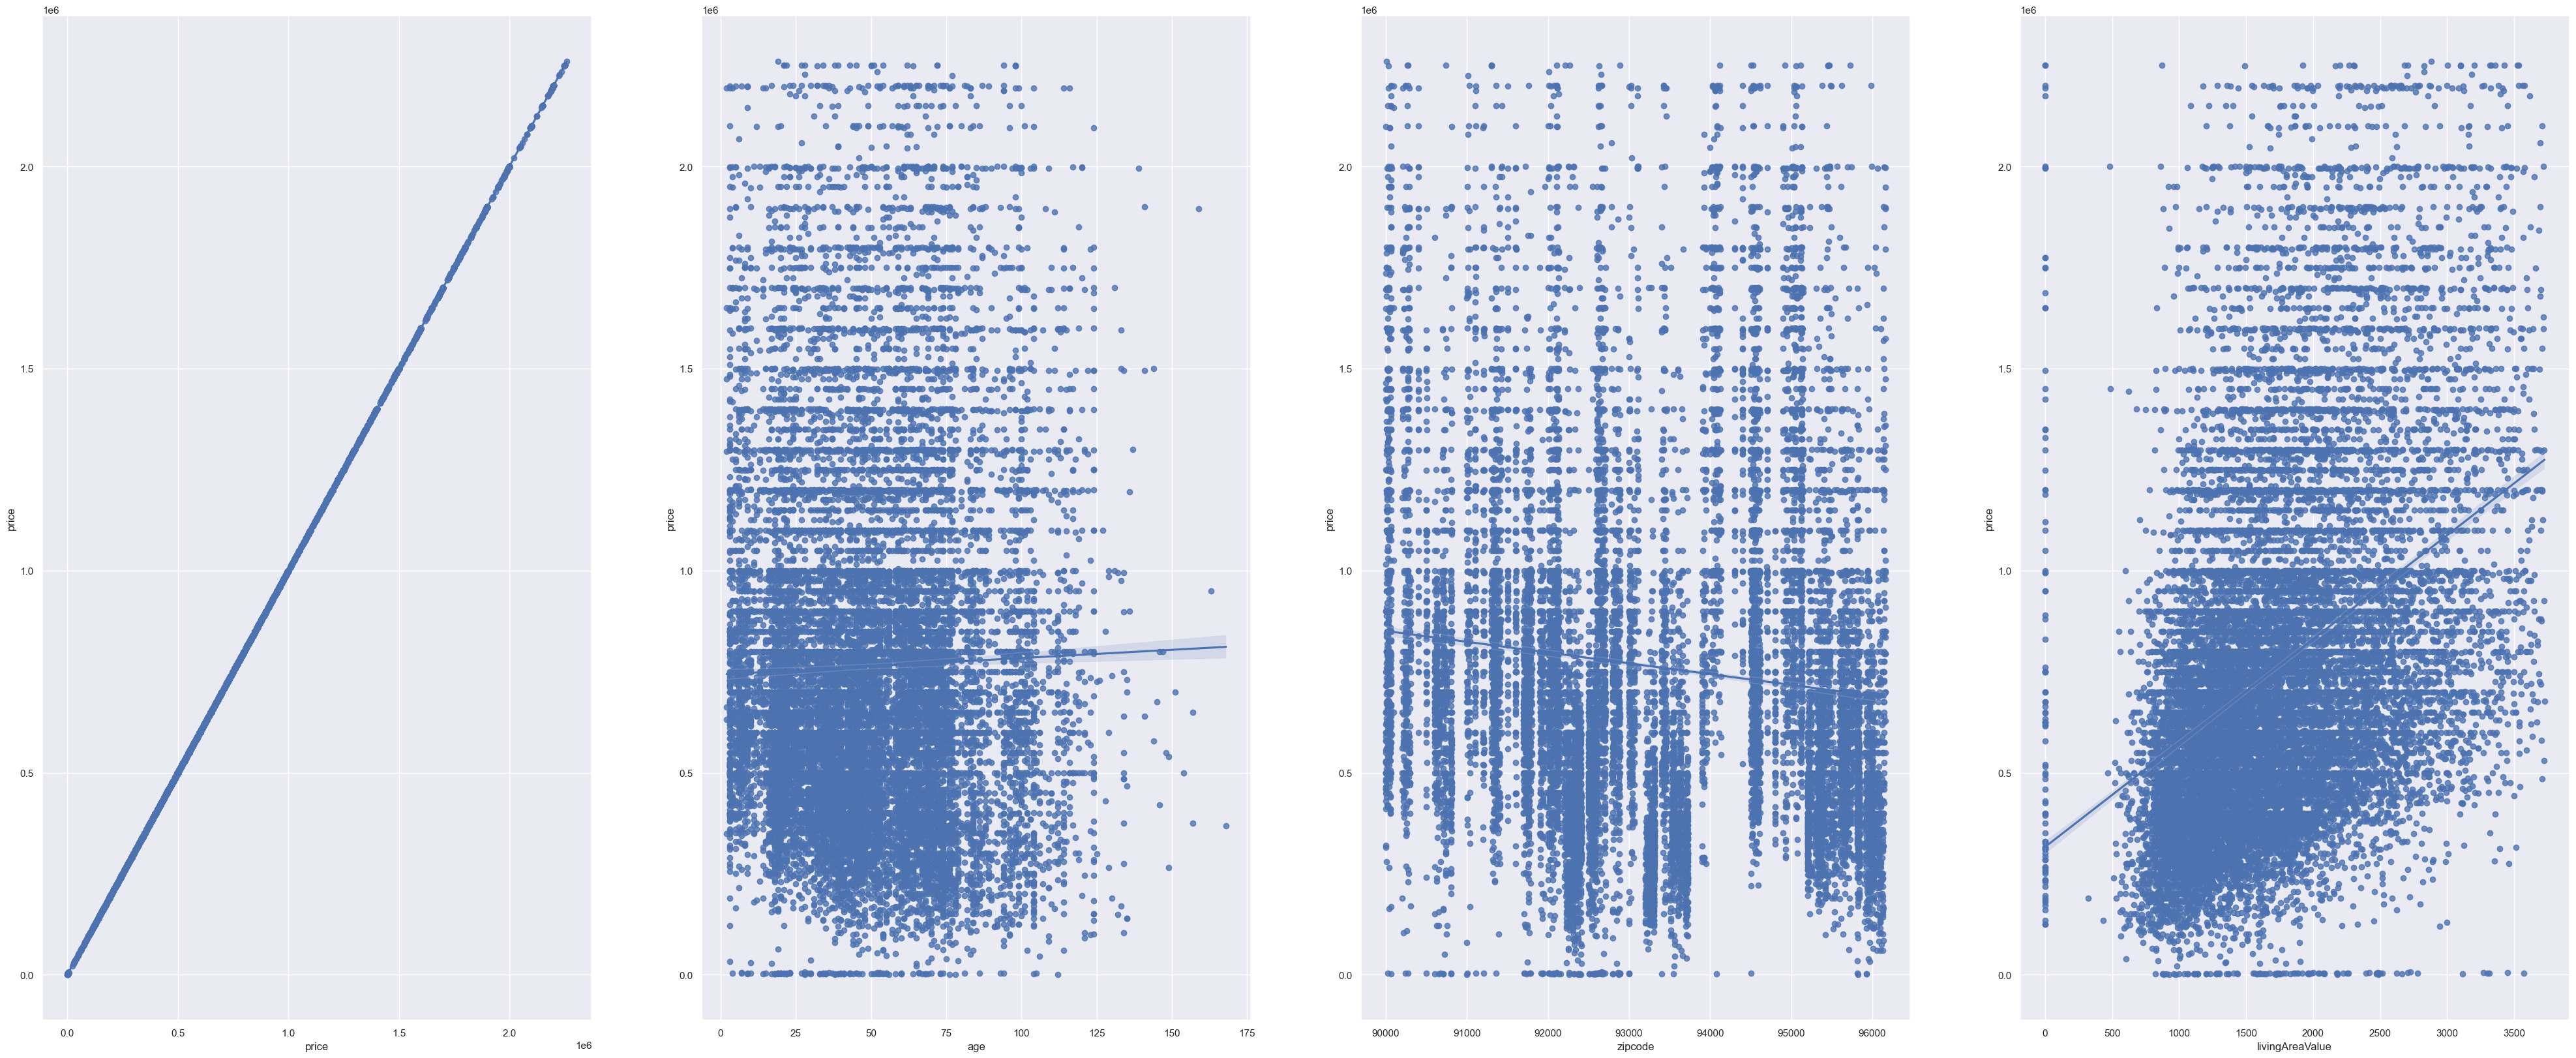

In [24]:
draw_regplots(clean_dataset,numerical_columns)

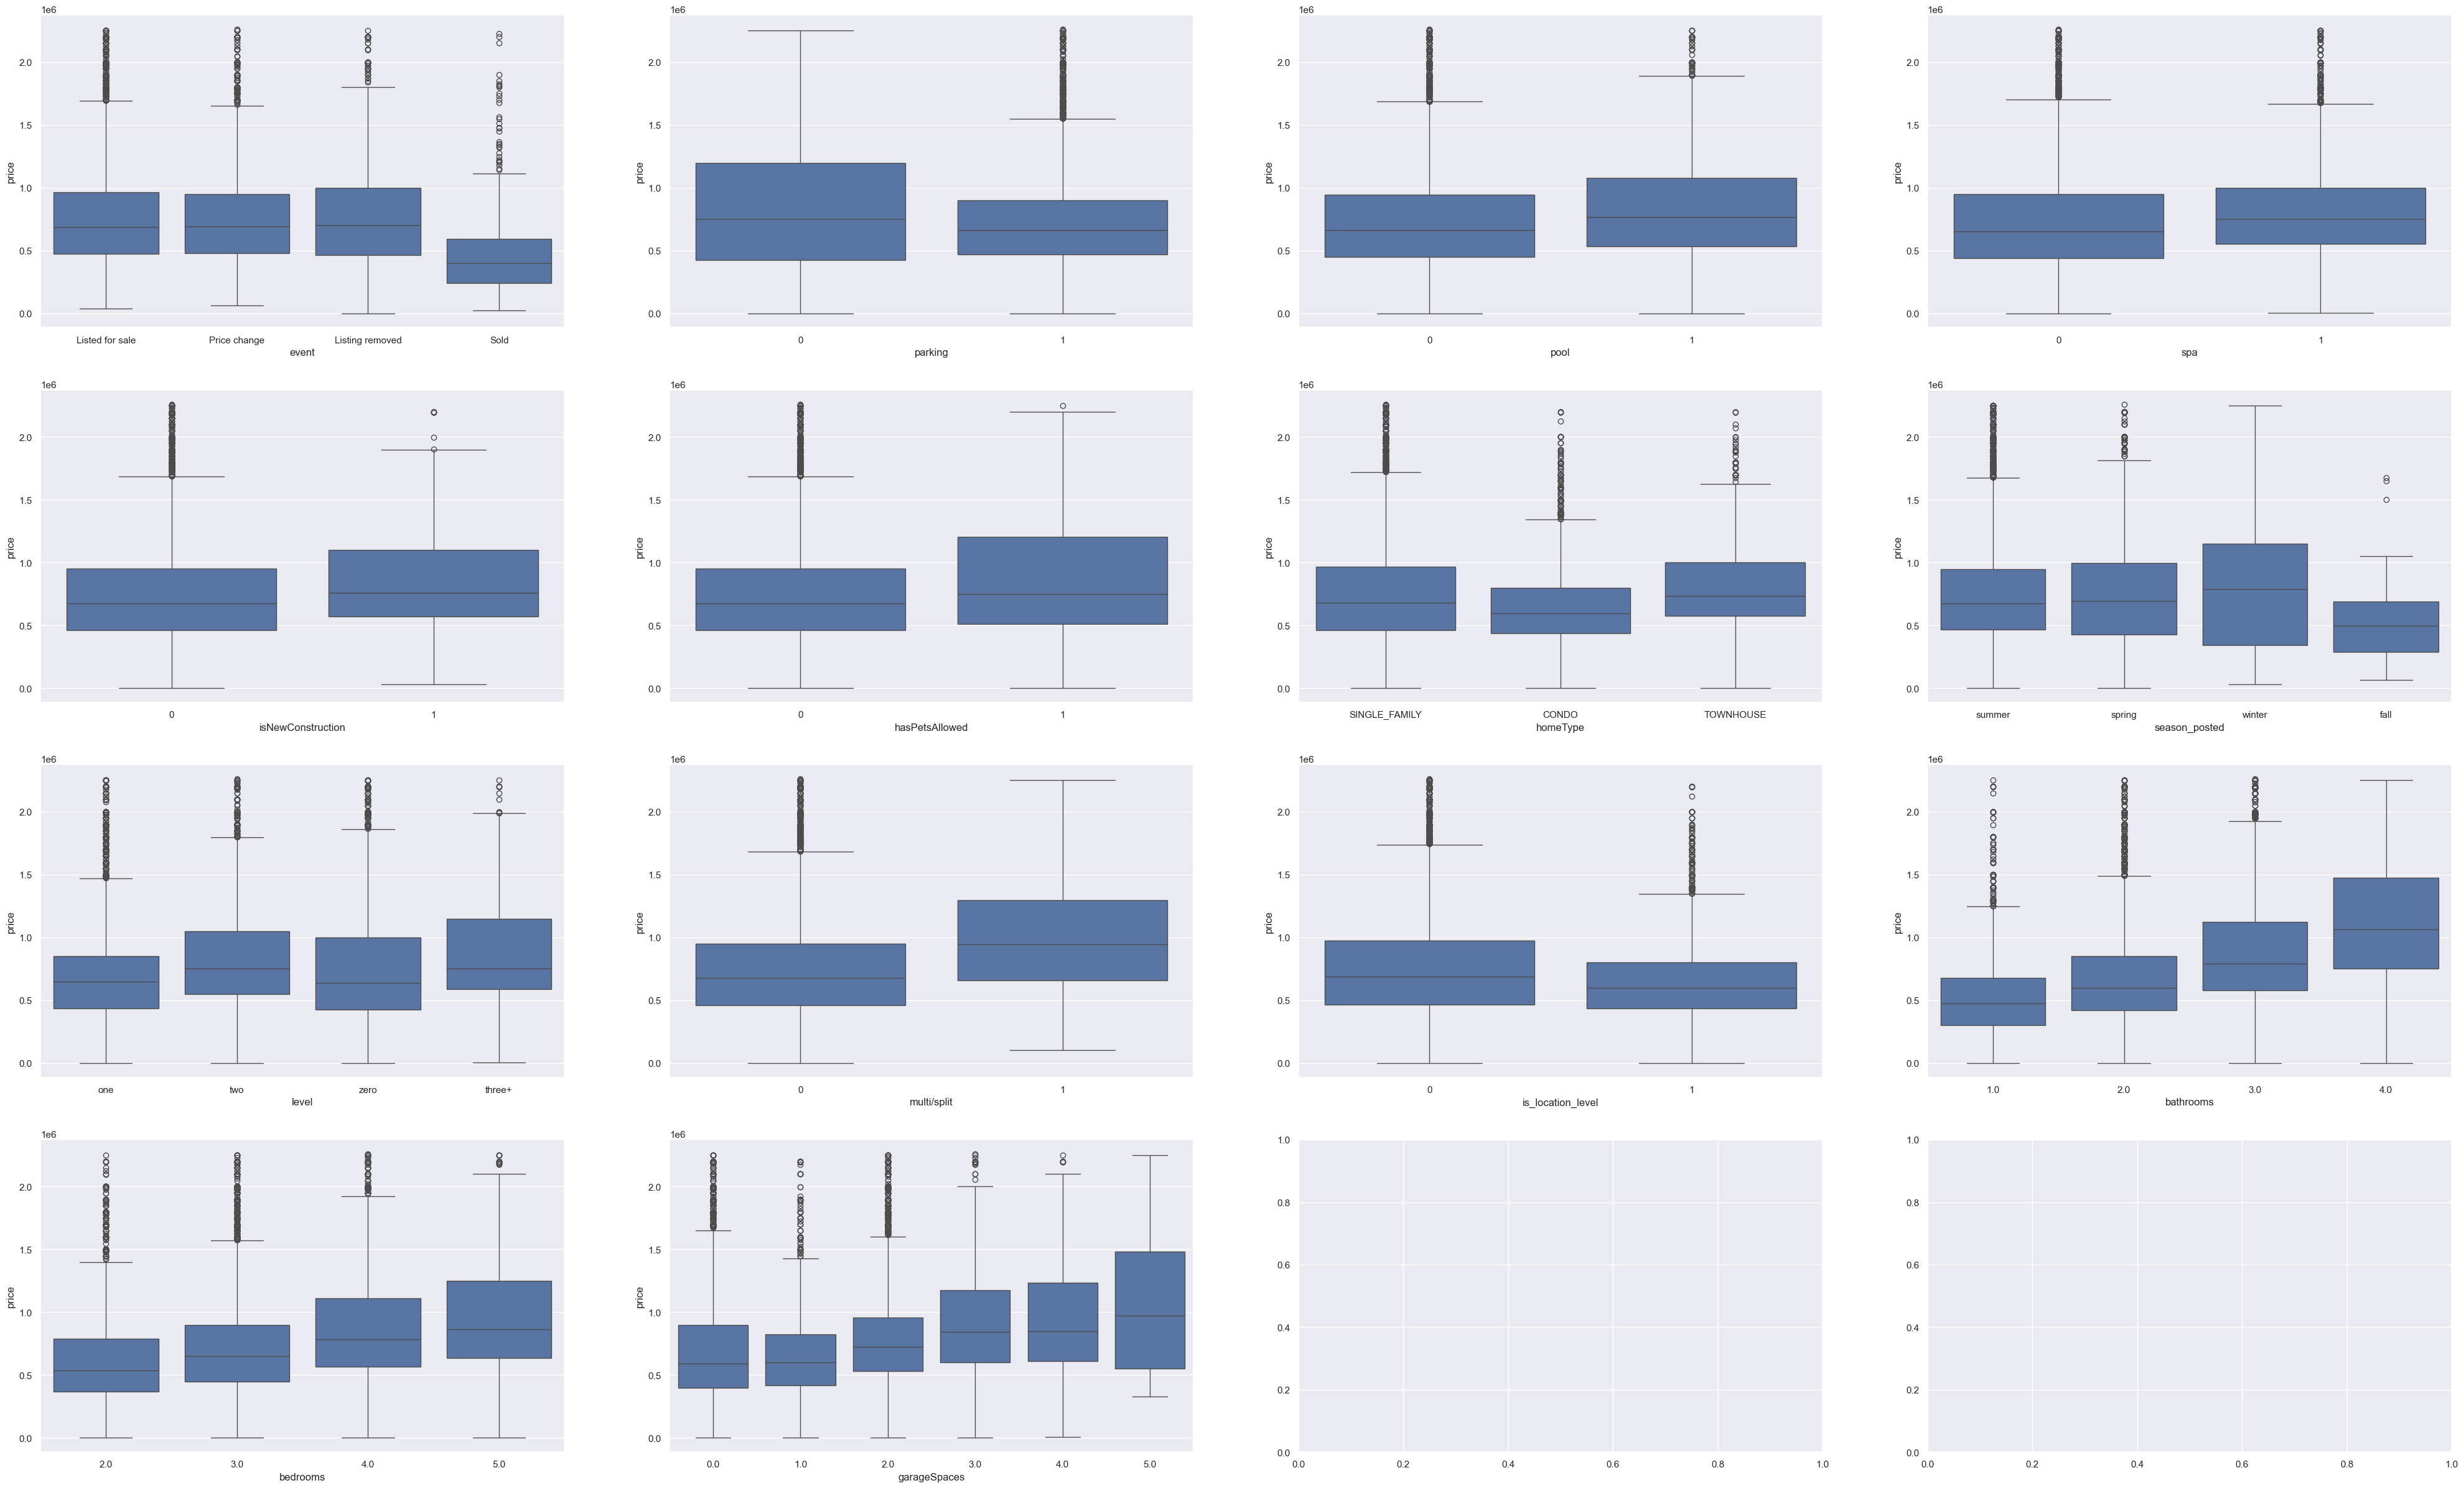

In [25]:
draw_boxplots(clean_dataset,categorical_columns)

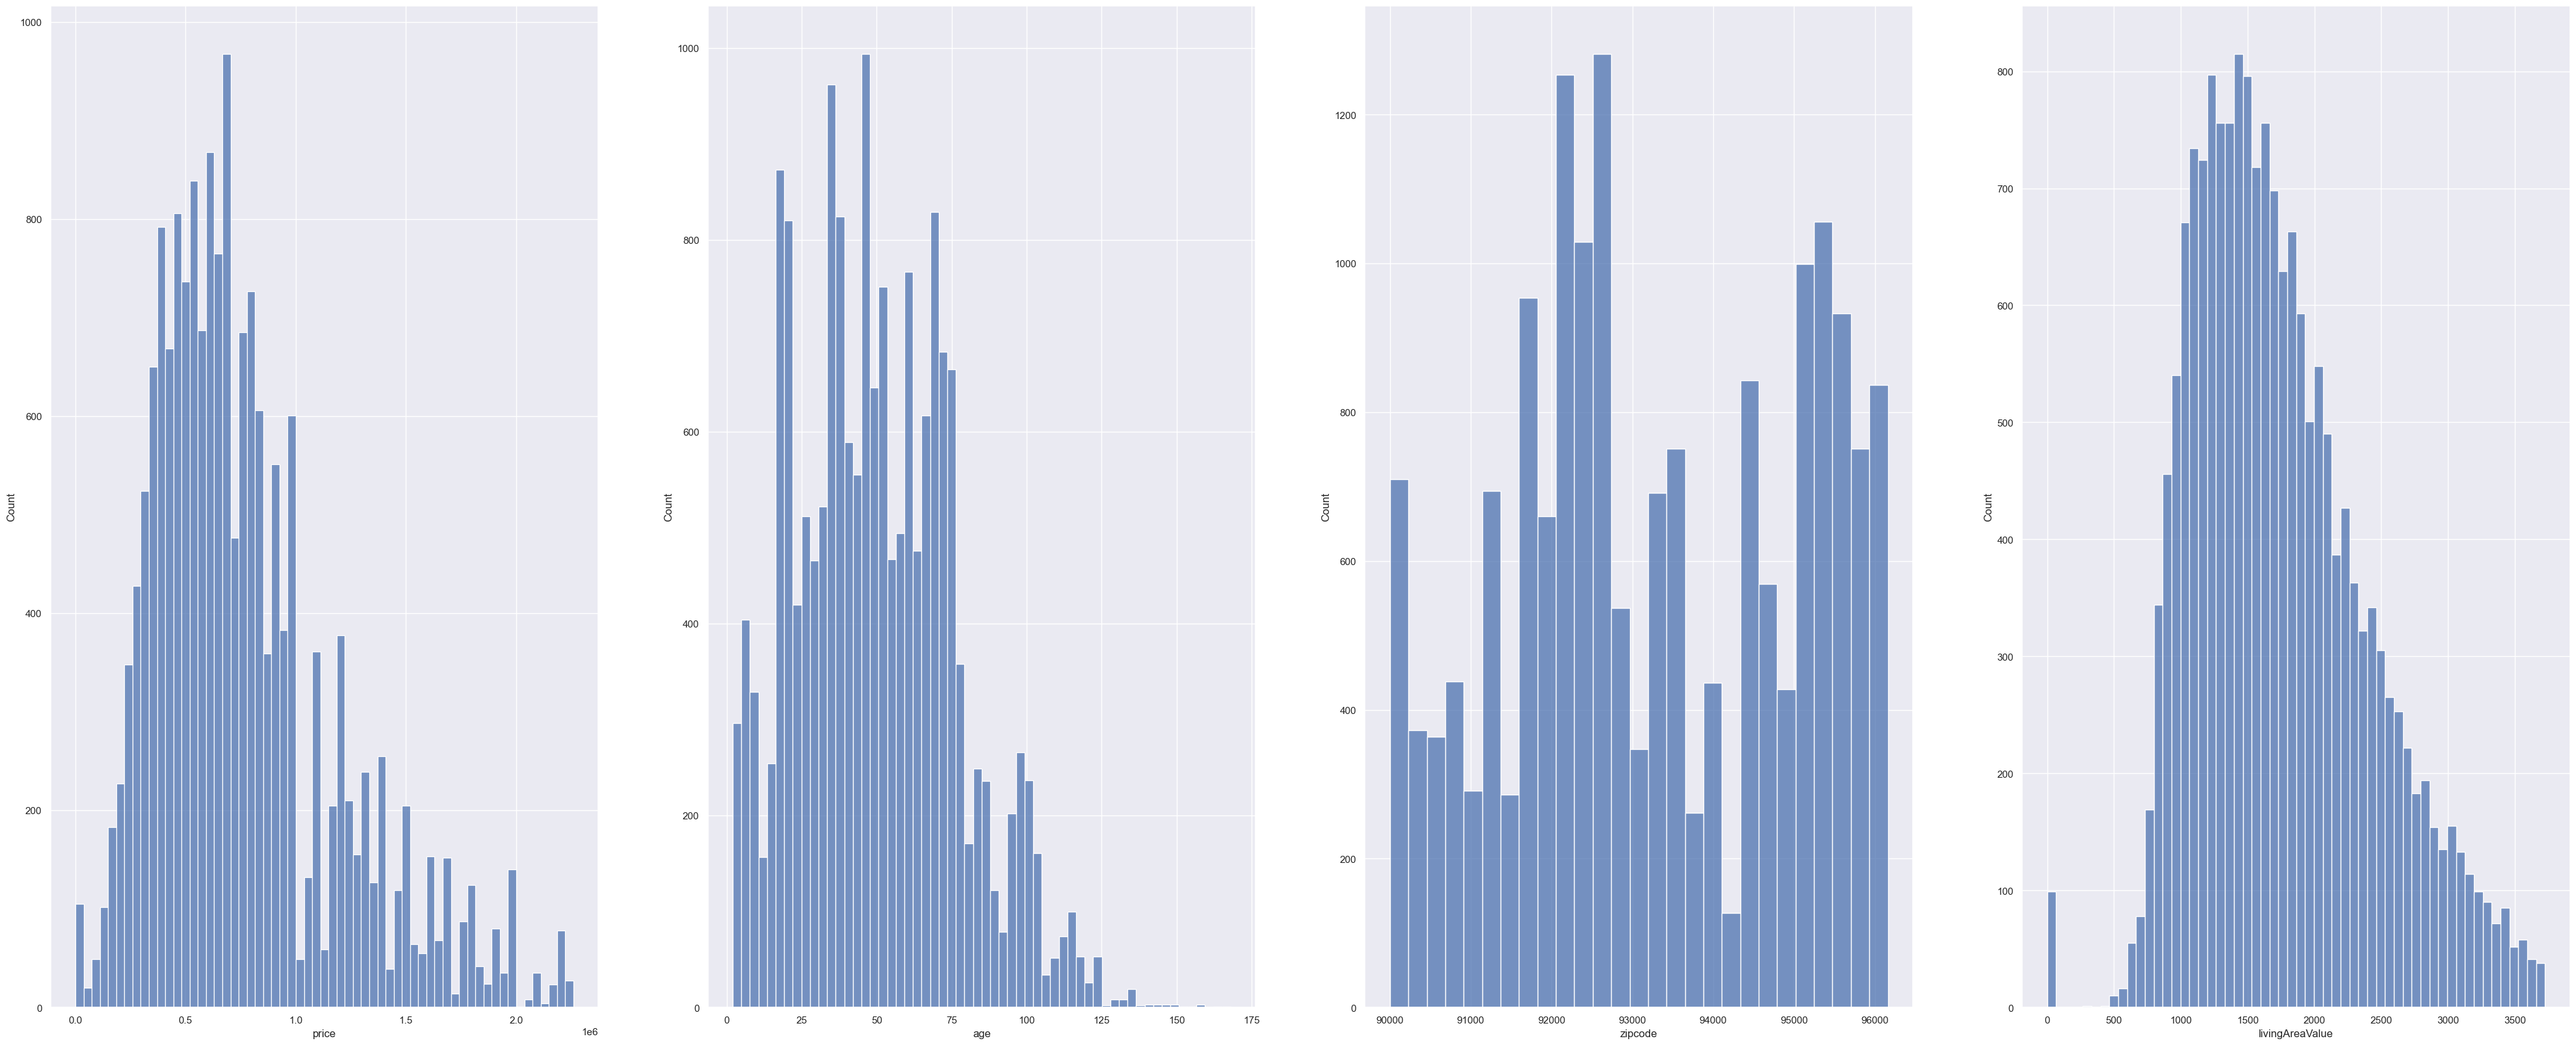

In [26]:
draw_histplots(clean_dataset,numerical_columns)

In [27]:
# value_counts of categorical columns
for col in categorical_columns:
    print(clean_dataset[col].value_counts())
    print('==================================')

event
Listed for sale    13216
Price change        2506
Listing removed     1406
Sold                 775
Name: count, dtype: int64
parking
1    14668
0     3235
Name: count, dtype: int64
pool
0    15702
1     2201
Name: count, dtype: int64
spa
0    14450
1     3453
Name: count, dtype: int64
isNewConstruction
0    17716
1      187
Name: count, dtype: int64
hasPetsAllowed
0    17607
1      296
Name: count, dtype: int64
homeType
SINGLE_FAMILY    14996
CONDO             2030
TOWNHOUSE          877
Name: count, dtype: int64
season_posted
summer    16161
spring     1621
winter       93
fall         28
Name: count, dtype: int64
level
one       6831
zero      6286
two       4190
three+     596
Name: count, dtype: int64
multi/split
0    17604
1      299
Name: count, dtype: int64
is_location_level
0    15873
1     2030
Name: count, dtype: int64
bathrooms
2.0    8372
3.0    6227
1.0    2228
4.0    1076
Name: count, dtype: int64
bedrooms
3.0    8179
4.0    4871
2.0    3758
5.0    1095
Name: count

### One-hot encoding

In [28]:
one_hot_columns = []
ordinal_columns = []
for column in clean_dataset.columns:
    if clean_dataset[column].dtype == 'object':
        if clean_dataset[column].nunique() <= 10:
            one_hot_columns.append(column)
        else:
            ordinal_columns.append(column)
print(f'Columns which we can apply one hot encoding: {one_hot_columns}')
print(f'Columns which we cannot apply one hot encoding: {ordinal_columns}')

Columns which we can apply one hot encoding: ['event', 'homeType', 'season_posted', 'level']
Columns which we cannot apply one hot encoding: ['city', 'county', 'street_name']


In [29]:
clean_dataset = pd.get_dummies(data = clean_dataset,
                               columns = one_hot_columns,
                               drop_first = True,
                               dtype = int)
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17903 entries, 1 to 35385
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   17903 non-null  float64
 1   city                    17903 non-null  object 
 2   zipcode                 17903 non-null  float64
 3   livingAreaValue         17903 non-null  float64
 4   bathrooms               17903 non-null  float64
 5   bedrooms                17903 non-null  float64
 6   parking                 17903 non-null  int64  
 7   garageSpaces            17903 non-null  float64
 8   pool                    17903 non-null  int64  
 9   spa                     17903 non-null  int64  
 10  isNewConstruction       17903 non-null  int64  
 11  hasPetsAllowed          17903 non-null  int64  
 12  county                  17903 non-null  object 
 13  price_of_total_area     17903 non-null  float64
 14  street_name             17903 non-null  obj

### Group age column

In [30]:
def group_ages(age):
    if age < 6:
        return 1
    elif age < 16:
        return 2
    elif age < 31:
        return 3
    elif age < 51:
        return 4
    else:
        return 5

clean_dataset['age_group'] = clean_dataset['age'].apply(group_ages)
clean_dataset.drop('age',axis=1,inplace=True)

In [31]:
clean_dataset['age_group'].value_counts()

age_group
5    8280
4    5092
3    3209
2     914
1     408
Name: count, dtype: int64

### Group livingAreaValue column

In [32]:
def group_area(area):
    if area < 1001:
        return 1
    elif area < 2001:
        return 2
    elif area < 3001:
        return 3
    else:
        return 4

clean_dataset['area_group'] = clean_dataset['livingAreaValue'].apply(group_area)
clean_dataset.drop('livingAreaValue',axis=1,inplace=True)

In [33]:
clean_dataset['area_group'].value_counts()

area_group
2    10605
3     4566
1     1827
4      905
Name: count, dtype: int64

In [34]:
clean_dataset['county'].value_counts()[-10:]

county
Kings County       30
Mono County        27
Lassen County      26
Mariposa County    25
Glenn County       21
Modoc County       20
Inyo County        10
Sierra County       9
Alpine County       7
Colusa County       4
Name: count, dtype: int64

In [35]:
clean_dataset['city'].value_counts()[-10:]

city
Canby             1
Alviso            1
Canyon Dam        1
Woody             1
West Hollywood    1
El Nido           1
Hydesville        1
El Macero         1
Edison            1
Fort bragg        1
Name: count, dtype: int64

In [36]:
clean_dataset['street_name'].value_counts()[-10:]

street_name
Magowan Dr           1
Golf View Ct         1
Hahman Dr            1
E Mall St            1
Voyager Dr           1
Saint James #84      1
Mayten Ave           1
Deerfield Ave #19    1
Santa Comba          1
S Ogden Dr           1
Name: count, dtype: int64

In [37]:
clean_dataset.drop(['city','street_name'],axis=1,inplace=True)

In [38]:
clean_dataset['county'].nunique()

58

### Target encoding county column

58


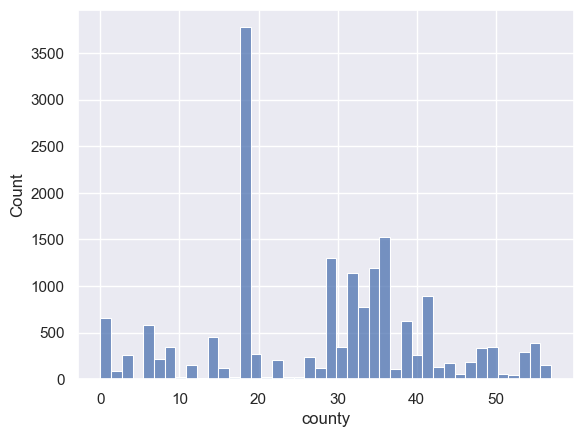

In [39]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
clean_dataset['county'] = label_encoder.fit_transform(clean_dataset['county'])
sns.histplot(clean_dataset['county'])
print(clean_dataset['county'].nunique())

In [40]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17903 entries, 1 to 35385
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   17903 non-null  float64
 1   zipcode                 17903 non-null  float64
 2   bathrooms               17903 non-null  float64
 3   bedrooms                17903 non-null  float64
 4   parking                 17903 non-null  int64  
 5   garageSpaces            17903 non-null  float64
 6   pool                    17903 non-null  int64  
 7   spa                     17903 non-null  int64  
 8   isNewConstruction       17903 non-null  int64  
 9   hasPetsAllowed          17903 non-null  int64  
 10  county                  17903 non-null  int64  
 11  price_of_total_area     17903 non-null  float64
 12  multi/split             17903 non-null  int64  
 13  is_location_level       17903 non-null  int64  
 14  event_Listing removed   17903 non-null  int

In [41]:
from sklearn.model_selection import train_test_split

X = clean_dataset.drop('price',axis=1)
y = clean_dataset['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

### Model selection

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_train_scaled = y_train_scaled.reshape(-1,)

#model_names = ['Linear Regression','SVR (rbf)','SVR (linear)','Decision Tree','Random Forest','XGBoost']
model_names = ['Random Forest']
#models = [LinearRegression(random_state = 0), SVR(kernel='rbf',random_state = 0),
#SVR(kernel='linear',random_state = 0),DecisionTreeRegressor(random_state = 0),RandomForestRegressor(random_state = 0),XGBRegressor(random_state = 0)]
models = [RandomForestRegressor(random_state = 0)]

In [43]:
def model_comparison(scoring_type, multiplier):
    print("================ With unscaled data =====================")
    mean_scores = []
    std_scores = []

    for model in models:
        model_pipeline = Pipeline(
        steps = [
            ('model', model)
            ]
        ) 
        scores =  multiplier * cross_val_score(model_pipeline,X_train,y_train,scoring=scoring_type,cv=10)
        mean_scores.append(scores.mean())
        std_scores.append(scores.std())
    
    mean_std_scores = list(zip(mean_scores,std_scores))

    mapped_scores = {model_name: mean_std_scores[i] for i, model_name in enumerate(model_names)}

    for model_name, score in mapped_scores.items():
        print(model_name)
        print(f"Mean: {score[0]}")
        print(f"Std: {score[1]}")
        print("===========================")

    # fig,ax = plt.subplots(1,2,figsize = (30,10))
    # sns.barplot(x=model_names,y=mean_scores,ax=ax[0])
    # sns.barplot(x=model_names,y=std_scores,ax=ax[1])
    # plt.show()
    
    print("================ With scaled data =====================")
    mean_scores = []
    std_scores = []

    for model in models:
        model_pipeline = Pipeline(
        steps = [
            ('scaler', StandardScaler()),
            ('model', model)
            ]
        ) 
        scores =  multiplier * cross_val_score(model_pipeline,X_train,y_train,scoring=scoring_type,cv=10)
        mean_scores.append(scores.mean())
        std_scores.append(scores.std())
    
    mean_std_scores = list(zip(mean_scores,std_scores))

    mapped_scores = {model_name: mean_std_scores[i] for i, model_name in enumerate(model_names)}

    for model_name, score in mapped_scores.items():
        print(model_name)
        print(f"Mean: {score[0]}")
        print(f"Std: {score[1]}")
        print("===========================")

    # fig,ax = plt.subplots(1,2,figsize = (30,10))
    # sns.barplot(x=model_names,y=mean_scores,ax=ax[0])
    # sns.barplot(x=model_names,y=std_scores,ax=ax[1])
    # plt.show()

### RMSE score

In [44]:
model_comparison(scoring_type = 'neg_root_mean_squared_error', multiplier = -1)

================ With unscaled data =====================
Random Forest
Mean: 29142.422449689115
Std: 12872.324609764248
================ With scaled data =====================
Random Forest
Mean: 29299.527896639047
Std: 13027.70737447185


### MAE score

In [45]:
model_comparison(scoring_type = 'neg_mean_absolute_error', multiplier = -1)

================ With unscaled data =====================
Random Forest
Mean: 1964.1712725464822
Std: 752.1440087745215
================ With scaled data =====================
Random Forest
Mean: 1974.768929313809
Std: 756.8297676685363


### R2 score

In [46]:
model_comparison(scoring_type = 'r2', multiplier = 1)

================ With unscaled data =====================
Random Forest
Mean: 0.9944061011989722
Std: 0.003944122807167417
================ With scaled data =====================
Random Forest
Mean: 0.9943305190340116
Std: 0.004041544895761766


### Model tuning

In [56]:
from sklearn.model_selection import GridSearchCV

selected_model = RandomForestRegressor()

parameters = {
    'n_estimators': [100],
    'max_depth': np.arange(1,20,1),
    'random_state': [0],
    'n_jobs': [-1]
}

grid_search = GridSearchCV(
    estimator=selected_model,
    param_grid=parameters,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    cv=10
)
grid_search.fit(X_train,y_train)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")

/opt/miniconda3/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best score: -28962.686715139534
Best parameters: {'max_depth': 16, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 0}


### Final model

In [57]:
final_model = RandomForestRegressor(max_depth = 16, n_estimators = 100, n_jobs = -1, random_state = 0)

final_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=16, n_jobs=-1, random_state=0)

In [58]:
from sklearn.metrics import r2_score,mean_absolute_error,root_mean_squared_error

def evaluate_model_on_test_set(model,X_test,y_test):
    
    y_pred = model.predict(X_test)
    
    rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
    r2 = r2_score(y_true=y_test,y_pred=y_pred)

    print(f"Test RMSE: {rmse}")
    print(f"Test MAE: {mae}")
    print(f"Test R2: {r2}")

In [59]:
evaluate_model_on_test_set(final_model,X_test,y_test)

Test RMSE: 21086.56608678791
Test MAE: 1301.690993261645
Test R2: 0.9974596017365869


### ANN

In [51]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_val_ann = X_train.sample(frac=0.2,random_state = 0)
X_train_ann = X_train.drop(X_val_ann.index)

y_val_ann = y_train[X_val_ann.index]
y_train_ann = y_train[X_train_ann.index]

X_train_scaled = scaler_X.fit_transform(X_train_ann)
X_val_scaled = scaler_X.transform(X_val_ann)

y_train_scaled = scaler_y.fit_transform(y_train_ann.values.reshape(-1,1))
y_val_scaled = scaler_y.transform(y_val_ann.values.reshape(-1,1))

In [52]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - SS_res / (SS_tot + K.epsilon())  # Adding epsilon to avoid division by zero

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.01,
    restore_best_weights=True
)

ann = keras.Sequential(
    [
        layers.InputLayer(input_shape=X.shape[1]),
        
        #layers.Dropout(rate = 0.3),
        layers.Dense(units = 10, activation = 'relu'),

        #layers.BatchNormalization(),
        #layers.Dropout(rate = 0.3),
        layers.Dense(units = 10, activation = 'relu'),

        #layers.BatchNormalization(),
        #layers.Dropout(rate = 0.3),
        layers.Dense(units = 10, activation = 'relu'),

        layers.Dense(units = 1)
    ]
)

ann.compile(
    loss = 'mean_squared_error',
    optimizer='adam',
    metrics = ['mae',r2_keras]
)

history = ann.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    batch_size = 64,
    epochs = 50,
    callbacks = [early_stopping]
)

Epoch 1/50


2024-09-26 00:00:12.301941: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-26 00:00:12.301975: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-26 00:00:12.301985: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-26 00:00:12.302020: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-26 00:00:12.302036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-09-26 00:00:12.768490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-09-26 00:00:12.797224: E te

180/180 [==============================] - 2s 9ms/step - loss: 2.5093 - mae: 1.1183 - r2_keras: -1.6555 - val_loss: 0.6465 - val_mae: 0.6184 - val_r2_keras: 0.3230
Epoch 2/50
180/180 [==============================] - 1s 8ms/step - loss: 0.8754 - mae: 0.6890 - r2_keras: -0.2304 - val_loss: 0.5361 - val_mae: 0.5582 - val_r2_keras: 0.4399
Epoch 3/50
180/180 [==============================] - 1s 8ms/step - loss: 0.6777 - mae: 0.5949 - r2_keras: 0.2830 - val_loss: 0.4848 - val_mae: 0.5326 - val_r2_keras: 0.4938
Epoch 4/50
180/180 [==============================] - 1s 7ms/step - loss: 0.5686 - mae: 0.5409 - r2_keras: 0.3773 - val_loss: 0.4660 - val_mae: 0.5184 - val_r2_keras: 0.5146
Epoch 5/50
180/180 [==============================] - 1s 6ms/step - loss: 0.5068 - mae: 0.4965 - r2_keras: 0.4745 - val_loss: 0.4185 - val_mae: 0.4915 - val_r2_keras: 0.5641
Epoch 6/50
180/180 [==============================] - 1s 6ms/step - loss: 0.4670 - mae: 0.4760 - r2_keras: 0.4194 - val_loss: 0.4015 - val_

<Axes: >

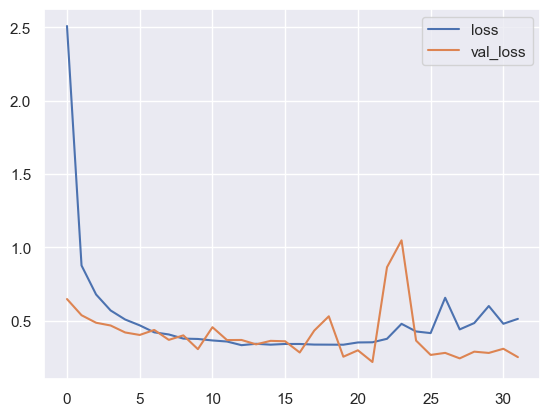

In [53]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()

In [54]:
X_test_scaled = scaler_X.transform(X_test)

In [55]:
predictions = scaler_y.inverse_transform(ann.predict(X_test_scaled)) 

ann_rmse_score = root_mean_squared_error(y_true=y_test,y_pred=predictions)
ann_mae_score = mean_absolute_error(y_true=y_test,y_pred=predictions)
ann_r2_score = r2_score(y_true=y_test,y_pred=predictions)

print(f"ANN RMSE score: {ann_rmse_score}")
print(f"ANN MAE score: {ann_mae_score}")
print(f"ANN R2 score: {ann_r2_score}")

112/112 [==============================] - 0s 1ms/step
ANN RMSE score: 186115.4145701838
ANN MAE score: 142371.07914601368
ANN R2 score: 0.802095908680271
